# HOMEWORK 2 
## Text Mining for Social Sciences
## Ivan Vallejo Vall, Daniel Velasquez Vergara, Saurav Poudel, Viviana Rosales 
### 11 May 2017

### Exercise 1

We start by reusing the code developed in homework 1 to create the document term matrix of the State of the Union addresses.

This time, however, we take as a document the whole speech for a given year, instead of each paragraph as we did in homework 1. LDA allows for multiple topic allocation per document. Each paragraph will probably have a single topic and therefore we would not take much advantage of multiple topic allocation, whereas at the aggregate level (year) we will certainly have multiple topics.

Moreover, it is also more relevant for the analysis to have an aggregate measure at the year level of topic evolution, rather than a detailed analysis per paragraph.

The following code creates the desired document term matrix, taking speeches starting from the year 1990 and applying a TF-IDF cut-off as specified in the figure below. For longer time periods and/or more terms selected, the procedure of the following steps would be the same, it would just require extra processing time. 

**Note:** the file 'speech_data_extend.txt' is needed to run the code, plus the nl corpora, which can be downloaded by typing nl.download().


 Number of unique words: 5183

 Number of selected words (cutoff 4.2 tf-idf): 2070


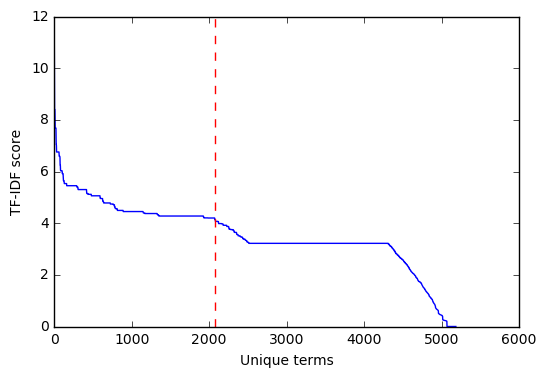

In [2]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import nltk as nl
from nltk.tokenize import word_tokenize
import pandas as pd
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import operator
# Download corpora if necessary: nl.download()

# Start analysis from this year
year = 1990
span = 2014-year+1

# Import state-of-the-union speech
text_raw = pd.read_csv('./speech_data_extend.txt', sep='\t')

# Consider addresses from 1970
text_data = text_raw.loc[text_raw['year']>=year, :]

# Reconstitute full speech for each year
text_year = pd.DataFrame(index=range(span), columns=['speech','year'])
for i in range(span):
    text_year['speech'][i]=' '.join(text_data['speech'][text_data['year']==year+i])
    text_year['year'][i]= year+i

#Processing of the data
stop_words = get_stop_words('en')
st = PorterStemmer()
docs = pd.Series(np.zeros(text_year.shape[0]))
tokens = [] #List of all words.

for i, line in enumerate(text_year['speech']):
    #Tokenize the data:
    doc_i = word_tokenize(line.lower())
    #Remove non-alphabetic characters:
    doc_i = [tok for tok in doc_i if tok.isalpha()]
    #Remove stopwords using a list of your choice:
    doc_i = [tok for tok in doc_i if tok not in stop_words]
    #Stem the data using the Porter stemmer:
    doc_i = [st.stem(tok) for tok in doc_i]

    tokens.extend(doc_i)
    docs.iloc[i] = doc_i

# Corpus-level tf-idf score for every term, and choose a cutoff below which to remove words.
unique_words = np.unique(tokens)
lw = len(unique_words) # Number of words
ld = len(docs) # Number of documents

word_count = nl.FreqDist(tokens)
tf = {k: 1+np.log(v) for k, v in word_count.items()}
df = {k: np.sum(list(map(lambda x: k in x, docs))) for k in word_count.keys()}
idf = {k: np.log(ld/v) for k, v in df.items()}
tfidf = {k : v * tf[k] for k, v in idf.items() if k in tf}

# Based on the ranking we select 500 words with highest tf-idf
# 1st we get the rank
rank = sorted(tfidf.items(), key=operator.itemgetter(1), reverse=True)
cutoff = rank[2000][1] -0.0001
# 2nd apply the cut-off
selected_words = {k: v for k, v in tfidf.items() if v>cutoff}
ls = len(selected_words) # number of selected words

%matplotlib inline
plt.plot([x[1] for x in rank])
plt.axvline(ls, color='red',linestyle='dashed')
plt.xlabel("Unique terms")
plt.ylabel("TF-IDF score")

print("\n Number of unique words: %d" %lw)

print("\n Number of selected words (cutoff %3.1f tf-idf): %d" %(cutoff,ls))

#Document-term matrix using words selected using the tf-idf score.
X = pd.DataFrame(np.zeros(shape = (ld, ls)), columns = selected_words.keys())

for w in selected_words.keys():
    X[w] = list(map(lambda x: x.count(w), docs))

We initialize the Gibbs sampler by setting the parameters ($\alpha$, $\eta$, #iterations and #topics)  and initializing the matrices we need to run it:

* $\boldsymbol{\theta}_d$: document specific mixing probabilities, D x K matrix.
* $\boldsymbol{\beta}_k$: topic specific term probabilities, K x V matrix.
* $\boldsymbol{z}_{d,n}$: topic allocation to each term of each document, D x V matrix.
* $\boldsymbol{n}_{d,k}$: number of words in document d that have topic allocation k, D x K matrix.
* $\boldsymbol{m}_{k,v}$: number of times topic k allocation variables generate term v, K x V matrix.

where

* **D:** number of documents. Dependent on the starting year and the aggregation. In our case, we cover the period 1990-2014 (25 years) and the level of aggregation is the whole speech of a given year, therefore D = 25.
* **K:** number of topics. A parameter of the Gibbs sampler. We try with 5 topics to facilitate the interpretation of the results (the more number of topics, the more difficult to associate each one with a given external phenomena). 
* **V:** number of terms. Dependent on the previous step TF-IDF cut-off applied. In our case, V = 2'070.

As proposed by Griffiths and Steyvers, we set $\eta = 200/V \approx 0.1$ and $\alpha = 50/K = 10$. In order to ensure that the algorithm has enough time to converge, we set #iterations = 12'000.   
  

In [5]:
#import packages
import numpy as np
import pandas as pd
from random import randint
import collections

# parameters document term matrix
D = X.shape[0]
V = X.shape[1]

# parameters gibbs sampler
topics = 5
alpha = 10
eta = 0.1
iterations = 12000

# initialize randomly (i.e. equal prob) matrix theta d
# topics numbered from 0 to k-1
theta_docs = 1/topics * np.ones(shape = (D, topics))

# initialize randomly (i.e. equal prob) matrix beta k
# topics numbered from 0 to k-1
beta_terms = 1/V * np.ones(shape = (topics,V))

# initialize the matrix z d,n
# topics numbered from 1 to k (cannot use 0 because it is used for non occurrences)
TA_terms = X.as_matrix()
for doc in range(D):
        for term in TA_terms[doc,:].nonzero()[0]:
            TA_terms[doc,term] = 1+np.random.multinomial(1,theta_docs[doc,:],size=1).argmax()

# initialize matrix n d,k
# topics numbered from 0 to k-1
TA_doc = np.zeros(shape = (D, topics))
for i in range(D):
    tmp = collections.Counter(TA_terms[i,:])
    for j in range(topics):
        TA_doc[i,j] = tmp[j+1]

# initialize matrix m k,v
# topics numbered from 0 to k-1
TA_v = np.zeros(shape = (topics,V))
for i in range(V):
    tmp = collections.Counter(TA_terms[:,i])
    for j in range(topics):
        TA_v[j,i] = tmp[j+1]
        


Next we run the GIBBS sampler following the steps outlined in the class slides:

* a) Sample from a multinomial distribution N times for the term-topic allocation: $\hspace{0.5cm} P(z_{d,n}|w_{d,n}=v,\boldsymbol{B},\boldsymbol{\theta_d}) = \dfrac{\theta^k_d \beta^v_k}{\sum_k \theta^k_d \beta^v_k}$
   
   b) Update $\boldsymbol{z}_{d,n}$, $\boldsymbol{n}_{d,k}$ and $\boldsymbol{m}_{k,v}$ based on the new topic allocations drawn from the multinomial.


* c) Sample from a Dirichlet D times for the document-specific mixing probabilities: $\hspace{0.5cm} P(\boldsymbol{\theta}_d|\alpha,\boldsymbol{z}_d) = Dir \hspace{0.1cm} (\alpha + n_{d,1}, \cdots, \alpha + n_{d,K})$


* d) Sample from a Dirichlet K times for the topic-specific term probabilities: $\hspace{0.5cm} P(\boldsymbol{\beta}_k|\eta,\boldsymbol{w},\boldsymbol{z}) = Dir \hspace{0.1cm} (\eta + m_{k,1}, \cdots, \eta + m_{k,V})$

In order to test convergence, we use the perplexity score at the end of each iteration:

$$ exp \left[ - \dfrac{ \sum\limits_{d=1}^{D} \sum\limits_{v=1}^{V} x_{d,v} log \left( \sum\limits_{k=1}^{K} \hat{\theta}_{d,k} \hat{\beta}_{k,v} \right) }{ \sum\limits_{d=1}^{D} N_d } \right] $$

where,

$$ \hat{\beta}_{k,v} = \dfrac{m_{k,v} + \eta }{\sum^V_{v=1} (m_{k,v} + \eta)} \hspace{2cm} \hat{\theta}_{d,k} = \dfrac{n_{d,k} + \alpha}{\sum^K_{k=1} (n_{d,k} + \alpha)}$$

In addition, we keep track of the evolution of topic allocation at each iteration for selected documents. We expect that topic allocation in a given document should become stable as the algorithm converges.

**Note:** the next chunk of code requires quite some time to run (about 45 min for 12'000 iterations). For a faster test, it can be run for, say, 1'000 iterations by just changing in the previous chunk of code the variable 'iterations' to 1000. The results obtained with 12'000 iterations have been saved and so can be retrieved afterwards.  


In [6]:
# To control time: import timeit; start_time = timeit.default_timer(); elapsed = timeit.default_timer() - start_time    

# GIBBS sampler
perplexity = np.zeros(iterations)
track = np.zeros(shape = (iterations,topics))
track2 = np.zeros(shape = (iterations,topics))
track3 = np.zeros(shape = (iterations,topics))
track4 = np.zeros(shape = (iterations,topics))
track5 = np.zeros(shape = (iterations,topics))
track6 = np.zeros(shape = (iterations,topics))
X_np = X.as_matrix()
Nd = X_np.sum()

for i in range(iterations):
    
    #start_time = timeit.default_timer()
    if i % 200 == 0:
        print("Iteration %d " %(i))    
    
    # Sample from a multinomial distribution N times for the term-topic allocation
    for doc in range(D):
        for term in TA_terms[doc,:].nonzero()[0]:
            # sample multinomial to get new topic allocation
            old_z = TA_terms[doc,term]-1
            p_z = np.multiply(theta_docs[doc,:],beta_terms[:,term])
            p_z_sum = p_z.sum()
            new_z = np.random.multinomial(1, p_z / p_z_sum).argmax()
            
            # update matrices depending on topic allocation
            TA_terms[doc,term] = new_z+1 # update topic-term matrix
            TA_doc[doc,old_z] -= 1 # decrease by one previous topic count in n d,k 
            TA_doc[doc,new_z] += 1 # increase by one new topic count in n d,k 
            TA_v[old_z,term] -= 1 # decrease by one previous topic count in m k,v 
            TA_v[new_z,term] += 1 # increase by one new topic count in m k,v 
            
    # Sample from a Dirichlet D times for the document-specific mixing probabilities
    for doc in range(D):
        theta_docs[doc,:] = np.random.dirichlet(alpha=(alpha+TA_doc[doc,:]))

    # Sample from a Dirichlet K times for the topic-specific term probabilities
    for topic in range(topics):
        beta_terms[topic,:] = np.random.dirichlet(alpha=(eta+TA_v[topic,:]))
    
    # calculate perplexity score
    theta_hat = TA_doc+alpha
    theta_hat = theta_hat / theta_hat.sum(axis=1, keepdims=True)
    beta_hat = TA_v+eta
    beta_hat = beta_hat / beta_hat.sum(axis=1, keepdims=True)
    perplexity[i]=0
    for doc in range(D):
        for term in TA_terms[doc,:].nonzero()[0]:
            perplexity[i] += X_np[doc,term] * np.log(np.multiply(theta_hat[doc,:],beta_hat[:,term]).sum())
    perplexity[i] = np.exp(-perplexity[i]/Nd)
    
    # Keep track of evolution of topic allocation 1
    track[i,:] = theta_docs[0,:]
    track2[i,:] = theta_docs[5,:]
    track3[i,:] = theta_docs[10,:]
    track4[i,:] = theta_docs[15,:]
    track5[i,:] = theta_docs[20,:]
    track6[i,:] = theta_docs[24,:]
    
    #print("-", end="")
    #elapsed = timeit.default_timer() - start_time
    #print("%4.3f" %elapsed)
    
print("Iteration %d " %iterations)
print("Done Gibbs sampler. Initial perplexity: %.1f ; final perplexity: %.1f" 
      %(perplexity[0],perplexity[iterations-1]))

Iteration 0 
Iteration 200 
Iteration 400 
Iteration 600 
Iteration 800 
Iteration 1000 
Iteration 1200 
Iteration 1400 
Iteration 1600 
Iteration 1800 
Iteration 2000 
Iteration 2200 
Iteration 2400 
Iteration 2600 
Iteration 2800 
Iteration 3000 
Iteration 3200 
Iteration 3400 
Iteration 3600 
Iteration 3800 
Iteration 4000 
Iteration 4200 
Iteration 4400 
Iteration 4600 
Iteration 4800 
Iteration 5000 
Iteration 5200 
Iteration 5400 
Iteration 5600 
Iteration 5800 
Iteration 6000 
Iteration 6200 
Iteration 6400 
Iteration 6600 
Iteration 6800 
Iteration 7000 
Iteration 7200 
Iteration 7400 
Iteration 7600 
Iteration 7800 
Iteration 8000 
Iteration 8200 
Iteration 8400 
Iteration 8600 
Iteration 8800 
Iteration 9000 
Iteration 9200 
Iteration 9400 
Iteration 9600 
Iteration 9800 
Iteration 10000 
Iteration 10200 
Iteration 10400 
Iteration 10600 
Iteration 10800 
Iteration 11000 
Iteration 11200 
Iteration 11400 
Iteration 11600 
Iteration 11800 
Iteration 12000 
Done Gibbs sampler. 

In [24]:
# save results to csv files so that we do not need to run the 12'000 iterations everytime we open the notebook
np.savetxt("./results/perplexity.csv",perplexity,delimiter=",")
np.savetxt("./results/track.csv",track,delimiter=",")
np.savetxt("./results/track2.csv",track2,delimiter=",")
np.savetxt("./results/track3.csv",track3,delimiter=",")
np.savetxt("./results/track4.csv",track4,delimiter=",")
np.savetxt("./results/track5.csv",track5,delimiter=",")
np.savetxt("./results/track6.csv",track6,delimiter=",")
np.savetxt("./results/theta_docs.csv",theta_docs,delimiter=",")
np.savetxt("./results/beta_terms.csv",beta_terms,delimiter=",")
np.savetxt("./results/TA_doc.csv",TA_doc,delimiter=",")
np.savetxt("./results/TA_v.csv",TA_v,delimiter=",")
np.savetxt("./results/TA_terms.csv",TA_terms,delimiter=",")

Next, we monitor the evolution of perplexity as well as the results of topic allocation for several documents. The charts below show the results using a moving average to smooth them, as otherwise oscillation make the charts difficult to read.

We note that perplexity does not clearly improve with the number of iterations, although there may be a marginal downward linear trend (see red line).

We also remark that the topic allocation of each speech does not converge with the number of iterations to a clear stable pattern. This also casts some doubt on the robustness of the results we may derive from the topic allocation matrix. 

For instance, in the address for the year 2000 topic 3 is the one with the highest probability at iteration 12'000 (about 0.3 probability), but at iteration 8'000 topic 5 had the highest probability (about 0.3), whereas topic 3 had only a probability of about 0.20 at iteration 8'000.

**Note:** if you want to plot the results of another simulation (say, with only 1000 iterations), you can run directly the second chunk of code below without loading the results of the 12'000 iterations. In that case, please adjust the variable sm_window to a smaller value (maybe 50, for 1'000 iterations) so that the moving average window is not too big for the total size of the sample. 

In [6]:
# load results from csv files saved earlier with the results of the 12'000 iterations
perplexity = np.loadtxt("./results/perplexity.csv",delimiter=",")
track = np.loadtxt("./results/track.csv",delimiter=",")
track2 = np.loadtxt("./results/track2.csv",delimiter=",")
track3 = np.loadtxt("./results/track3.csv",delimiter=",")
track4 = np.loadtxt("./results/track4.csv",delimiter=",")
track5 = np.loadtxt("./results/track5.csv",delimiter=",")
track6 = np.loadtxt("./results/track6.csv",delimiter=",")
theta_docs = np.loadtxt("./results/theta_docs.csv",delimiter=",")
beta_terms = np.loadtxt("./results/beta_terms.csv",delimiter=",")
TA_doc = np.loadtxt("./results/TA_doc.csv",delimiter=",")
TA_v = np.loadtxt("./results/TA_v.csv",delimiter=",")
TA_terms = np.loadtxt("./results/TA_terms.csv",delimiter=",")

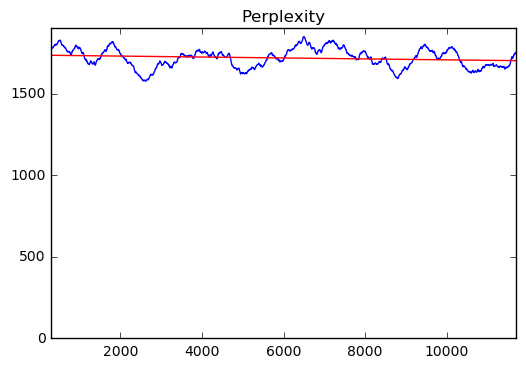

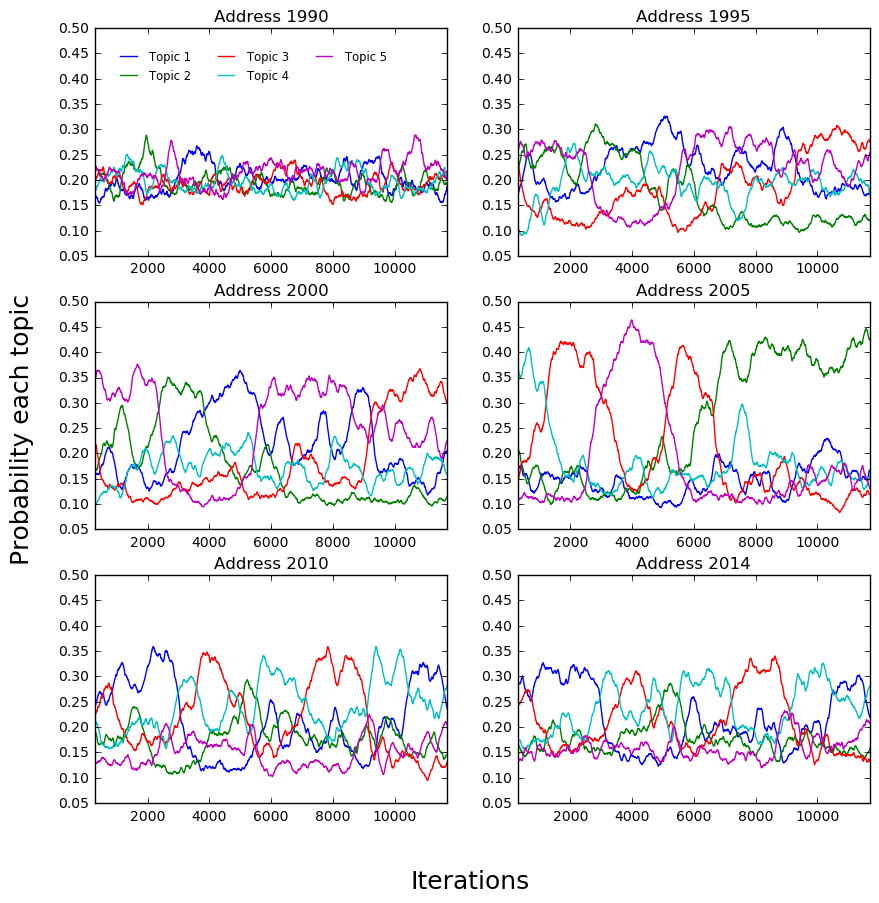

In [17]:
# Perplexity
# smooth window: necessary as otherwise there is too much volatility and figures are difficult to read
sm_window=300
# smooth and convert to pandas
perplexity_df = pd.DataFrame(np.convolve(perplexity,1/sm_window * np.ones(sm_window),'same'))
# add trendline
z = np.polyfit(range(iterations), perplexity, 1)
p = np.poly1d(z)
perplexity_df['trend'] = p(range(iterations))
# plot
perplexity_df.plot(legend=False, title="Perplexity", color=['blue','red'],xlim=(sm_window,iterations-sm_window), ylim=(0,1900))

# Topic allocation for selected documents
# smooth and convert to pandas
track_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track))
track2_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track2))
track3_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track3))
track4_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track4))
track5_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track5))
track6_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track6))

# Create legend text
legend = []
for i in range(topics):
    legend.append("Topic " + str((i+1))) 
# Create a grid to fit 6 charts
fig, ax = plt.subplots(3,2, figsize=(10,10), sharex =True, sharey=True)
# plot first chart
ax1 = track_df.plot(ax=ax[0,0], title="Address 1990",xlim=(sm_window,iterations-sm_window))
# add legend to 1st chart
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(loc="upper left", frameon= False,borderaxespad=1.5, labels=legend, ncol=3,fontsize='small')
plt.setp(ax1.get_xticklabels(),visible=True)
# plot the rest without legend
track2_df.plot(ax=ax[0,1], legend=False, title="Address 1995",xlim=(sm_window,iterations-sm_window))
track3_df.plot(ax=ax[1,0], legend=False, title="Address 2000", xlim=(sm_window,iterations-sm_window))
track4_df.plot(ax=ax[1,1], legend=False, title="Address 2005",xlim=(sm_window,iterations-sm_window))
track5_df.plot(ax=ax[2,0], legend=False, title="Address 2010",xlim=(sm_window,iterations-sm_window))
track6_df.plot(ax=ax[2,1], legend=False, title="Address 2014",xlim=(sm_window,iterations-sm_window))
# add x,y labels all charts
for chart in ax.flatten():
    for tk in chart.get_yticklabels():
        tk.set_visible(True)
    for tk in chart.get_xticklabels():
        tk.set_visible(True)
fig.text(0.5, 0.04, 'Iterations', ha='center', size=18)
fig.text(0.04, 0.5, 'Probability each topic', va='center', size=18, rotation='vertical')
fig.show()

We take the results of the Gibbs sampler (with the caveats mentioned about the convergence of the results) and produce a word cloud for each topic.

Based on the most prominent words highlighted in these diagrams, it is difficult to individuate any obvious link between each topic and external phenomena. For instance, topic 3 seems to relate to some foreign policy issues (Egypt, Syria, Kosovo), but similar terms also appear in topic 5 (e.g. Syria and Qadhafi).

Topic 1 seems to have some economic connotations (merge, shrink, jone), but the terms are rather general. Topic 2 includes some industrial/labor terms (invent, automat, overtime), whereas topic 4 is hard to relate to a particular external subject since term are rather heterodox. 

From this analysis we can conclude that 5 topics are probably too few to extract distinct meaning from the State of the Union Addresses.  

**Note:** the next chunk of code requires the package WordCloud.

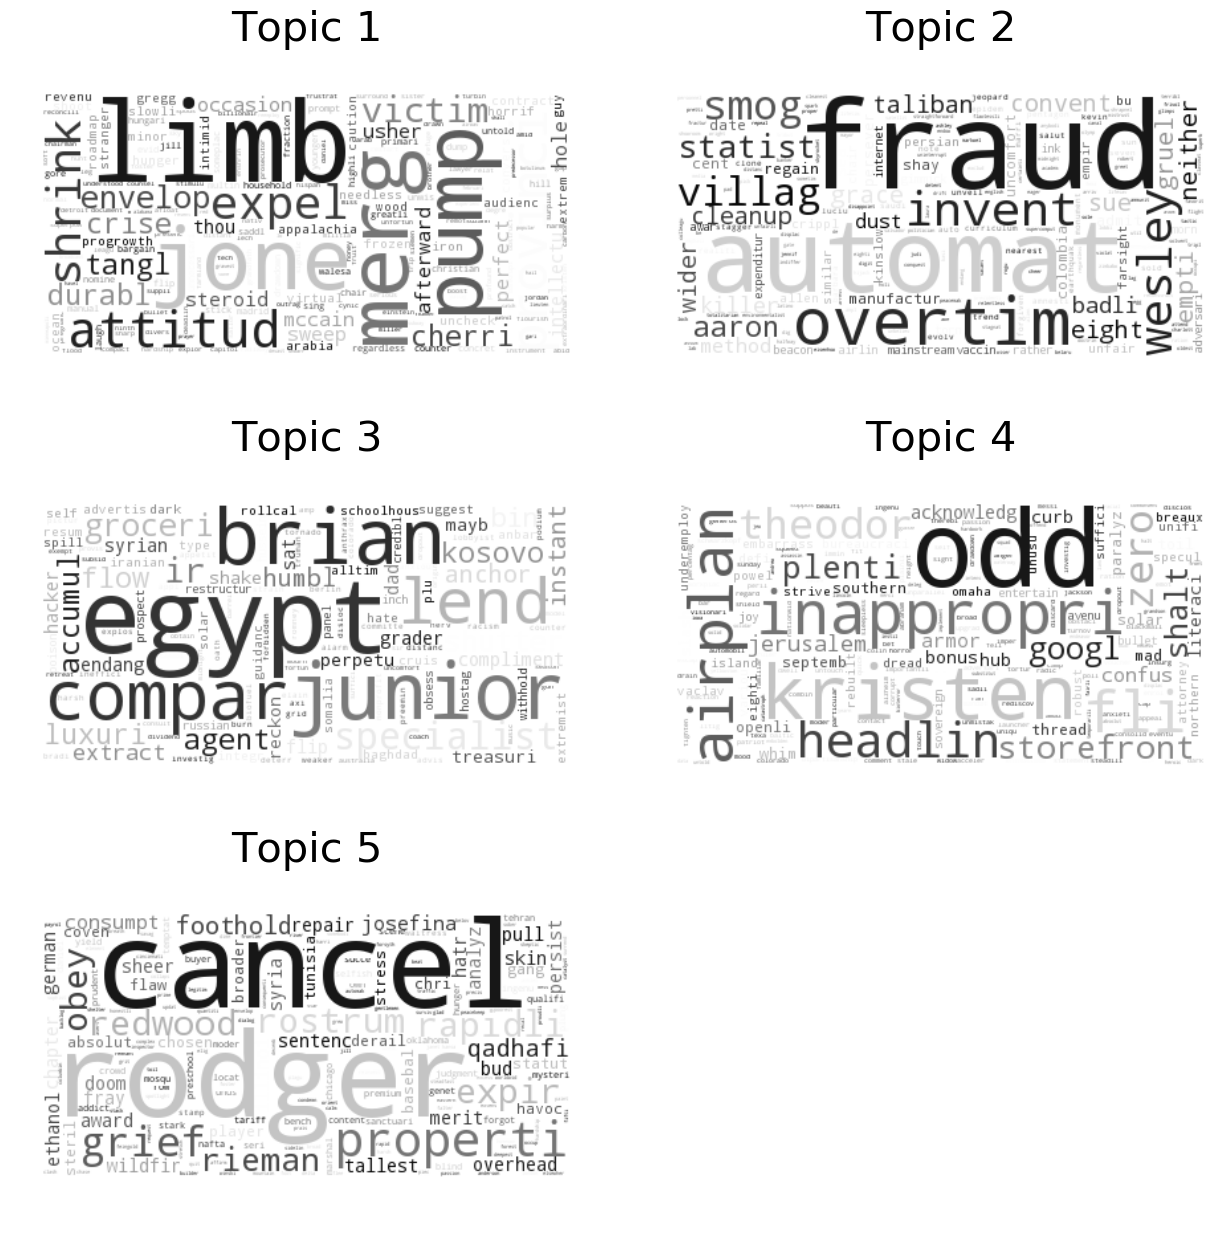

In [97]:
from wordcloud import WordCloud

# load word frequencies for each topic
topic1 = {}
for i,term in enumerate(X.columns):
    topic1[term] = beta_terms[0,i]

topic2 = {}
for i,term in enumerate(X.columns):
    topic2[term] = beta_terms[1,i]

topic3 = {}
for i,term in enumerate(X.columns):
    topic3[term] = beta_terms[2,i]

topic4 = {}
for i,term in enumerate(X.columns):
    topic4[term] = beta_terms[3,i]

topic5 = {}
for i,term in enumerate(X.columns):
    topic5[term] = beta_terms[4,i]

# calculate wordclouds
wordcloud1 = WordCloud(relative_scaling=1,background_color='white', colormap="binary", random_state=3).generate_from_frequencies(topic1)
wordcloud2 = WordCloud(relative_scaling=1,background_color='white', colormap="binary", random_state=3).generate_from_frequencies(topic2)
wordcloud3 = WordCloud(relative_scaling=1,background_color='white', colormap="binary", random_state=4).generate_from_frequencies(topic3)
wordcloud4 = WordCloud(relative_scaling=1,background_color='white', colormap="binary", random_state=3).generate_from_frequencies(topic4)
wordcloud5 = WordCloud(relative_scaling=1,background_color='white', colormap="binary", random_state=3).generate_from_frequencies(topic5)

#plot them
fig, ax = plt.subplots(3,2, figsize=(15,15))
ax[0,0].axis("off")
ax[0,0].set_title("Topic 1\n", size=30)
ax[0,0].imshow(wordcloud1, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title("Topic 2\n", size=30)
ax[0,1].imshow(wordcloud2, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title("Topic 3\n", size=30)
ax[1,0].imshow(wordcloud3, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title("Topic 4\n", size=30)
ax[1,1].imshow(wordcloud4, interpolation='bilinear')
ax[2,0].axis("off")
ax[2,0].set_title("Topic 5\n", size=30)
ax[2,0].imshow(wordcloud5, interpolation='bilinear')
ax[2,1].axis("off")
plt.show()


### Exercise 2

Now we run a collapsed Gibbs sampler for the same parameter values (i.e. Dirichlet hyperparameters and K) and documents in exercise 1. We use the ‘lda’ package. 


In [2]:
##2. Collapsed GIBBS SAMPLER:
import lda

# parameters document term matrix
D = X.shape[0]
V = X.shape[1]

# parameters gibbs sampler
topics = 5
alpha = 10
eta = 0.1
iterations = 12000

model = lda.LDA(n_topics=5, n_iter=iterations, alpha = alpha, eta = eta, random_state=1)
model.fit(np.array(X))


INFO:lda:n_documents: 25
INFO:lda:vocab_size: 2070
INFO:lda:n_words: 9013
INFO:lda:n_topics: 5
INFO:lda:n_iter: 12000
INFO:lda:<0> log likelihood: -88973
INFO:lda:<10> log likelihood: -76850
INFO:lda:<20> log likelihood: -75296
INFO:lda:<30> log likelihood: -74573
INFO:lda:<40> log likelihood: -74200
INFO:lda:<50> log likelihood: -73964
INFO:lda:<60> log likelihood: -73810
INFO:lda:<70> log likelihood: -74100
INFO:lda:<80> log likelihood: -74151
INFO:lda:<90> log likelihood: -73797
INFO:lda:<100> log likelihood: -73815
INFO:lda:<110> log likelihood: -74119
INFO:lda:<120> log likelihood: -74069
INFO:lda:<130> log likelihood: -73977
INFO:lda:<140> log likelihood: -74176
INFO:lda:<150> log likelihood: -74018
INFO:lda:<160> log likelihood: -74064
INFO:lda:<170> log likelihood: -73958
INFO:lda:<180> log likelihood: -74244
INFO:lda:<190> log likelihood: -74057
INFO:lda:<200> log likelihood: -73872
INFO:lda:<210> log likelihood: -73919
INFO:lda:<220> log likelihood: -73757
INFO:lda:<230> log 

a) We plot the perplexity across the first 1000 sampling iterations beginning from 5 different starting values. In this case we observe the perpexitly decreases quickly during the first iterations and then it stabilizes. When compared with the perplexity of the uncollapsed Gibbs sampler (see exercise 1), we conclude the collapsed version of the sampler burns much faster.



In [4]:
##Perplexity
def perplexity_iter(n_iter, X, K, alpha = np.arange(0.1,1,0.3), eta = np.arange(0.1,1,0.3), n_runs = 5):
    perp = np.zeros(shape = (n_runs, int(n_iter/10)))
    alpha_runs = np.zeros(n_runs)
    eta_runs = np.zeros(n_runs)
    for i in range(n_runs):
        alphai = float(np.random.choice(alpha, 1))
        etai = float(np.random.choice(eta, 1))
        alpha_runs[i]=alphai
        eta_runs[i]=etai
        model = lda.LDA(n_topics=K, n_iter=n_iter, alpha = alphai, eta = etai, random_state=1)
        model.fit(np.array(X))
        perp[i] = np.exp(np.negative(model.loglikelihoods_/np.sum(np.array(X))))
    return(perp, alpha_runs, eta_runs)

n_runs = 5
perplex, alpha_vector, eta_vector = perplexity_iter(n_iter = 1000, X = X, K = topics, n_runs = n_runs)



INFO:lda:n_documents: 25
INFO:lda:vocab_size: 2070
INFO:lda:n_words: 9013
INFO:lda:n_topics: 5
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -85254
INFO:lda:<10> log likelihood: -75641
INFO:lda:<20> log likelihood: -72052
INFO:lda:<30> log likelihood: -71458
INFO:lda:<40> log likelihood: -70959
INFO:lda:<50> log likelihood: -70249
INFO:lda:<60> log likelihood: -70097
INFO:lda:<70> log likelihood: -70155
INFO:lda:<80> log likelihood: -70230
INFO:lda:<90> log likelihood: -70063
INFO:lda:<100> log likelihood: -70300
INFO:lda:<110> log likelihood: -70139
INFO:lda:<120> log likelihood: -70140
INFO:lda:<130> log likelihood: -70182
INFO:lda:<140> log likelihood: -70510
INFO:lda:<150> log likelihood: -70161
INFO:lda:<160> log likelihood: -70116
INFO:lda:<170> log likelihood: -70268
INFO:lda:<180> log likelihood: -70405
INFO:lda:<190> log likelihood: -70413
INFO:lda:<200> log likelihood: -70290
INFO:lda:<210> log likelihood: -70081
INFO:lda:<220> log likelihood: -70282
INFO:lda:<230> log l

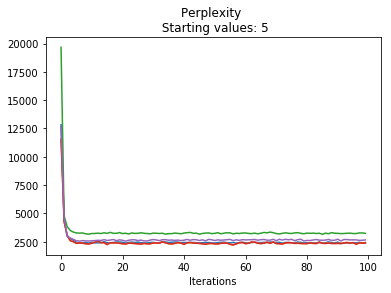

In [5]:
for i in range(n_runs):
        plt.plot(perplex[i][0:])
plt.xlabel('Iterations')
plt.title('Perplexity \n Starting values: 5')
plt.savefig('perp_nclda.png', bbox_inches='tight')
plt.show()



b) Now we consider estimates of the predictive distribution of $\theta_{d}$ for the selected documents in the previous exercise. The plots below compare the estimated topic distribution for the addresses corresponding to 1995, 2000, 2005 and 2010.

We oberserve that predictive topic distributions for the uncollapsed and collapsed samplers can be significanlty different and this could be due to the fact that the uncollapsed sampler did not converge. As we saw in the previous exercise, in the case of the uncollapsed sampler the topic distribution for the selected documents can be highly variable across iterations. However, in certain documents both sampler allow us to get the same conclusions. For example, for the 1990 address both sampler assign a similar distribution to all topics. For the 1995 address both samplers estimate a high probability to topic 3 and low probability to topics 2 and 4. 

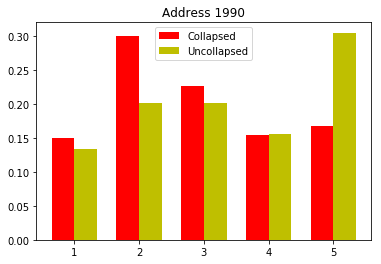

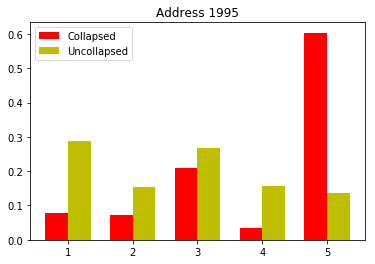

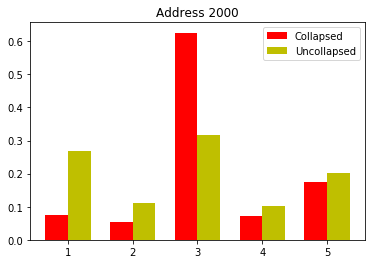

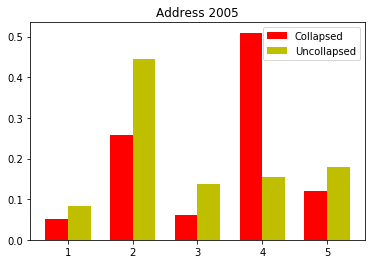

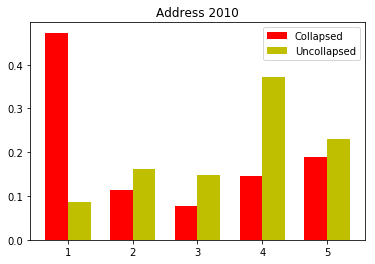

In [8]:
track = pd.read_csv("./results/track.csv",sep=",", header = None)
track2 = pd.read_csv("./results/track2.csv",sep=",", header = None)
track3 = pd.read_csv("./results/track3.csv",sep=",", header = None)
track4 = pd.read_csv("./results/track4.csv",sep=",", header = None)
track5 = pd.read_csv("./results/track5.csv",sep=",", header = None)

ind = np.arange(topics)  # the x locations for the groups
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, model.doc_topic_[0], width, color='r')
rects2 = ax.bar(ind + width, track.iloc[iterations-1], width, color='y')
ax.set_title('Address 1990')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((np.arange(topics)+1))
ax.legend((rects1[0], rects2[0]), ('Collapsed', 'Uncollapsed'))
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(ind, model.doc_topic_[5], width, color='r')
rects2 = ax.bar(ind + width, track2.iloc[iterations-1], width, color='y')
ax.set_title('Address 1995')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((np.arange(topics)+1))
ax.legend((rects1[0], rects2[0]), ('Collapsed', 'Uncollapsed'))
plt.show()


fig, ax = plt.subplots()
rects1 = ax.bar(ind, model.doc_topic_[10], width, color='r')
rects2 = ax.bar(ind + width, track3.iloc[iterations-1], width, color='y')
ax.set_title('Address 2000')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((np.arange(topics)+1))
ax.legend((rects1[0], rects2[0]), ('Collapsed', 'Uncollapsed'))
plt.show()


fig, ax = plt.subplots()
rects1 = ax.bar(ind, model.doc_topic_[15], width, color='r')
rects2 = ax.bar(ind + width, track4.iloc[iterations-1], width, color='y')
ax.set_title('Address 2005')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((np.arange(topics)+1))
ax.legend((rects1[0], rects2[0]), ('Collapsed', 'Uncollapsed'))
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(ind, model.doc_topic_[20], width, color='r')
rects2 = ax.bar(ind + width, track5.iloc[iterations-1], width, color='y')
ax.set_title('Address 2010')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((np.arange(topics)+1))
ax.legend((rects1[0], rects2[0]), ('Collapsed', 'Uncollapsed'))
plt.show()




### Exercise 3

Now we take paragraphs of state-of-the-union addresses from 1946 onwards. Each paragraph corresponds to a document and is associated with one of two political parties: Democrat or Republican. The goal is to implement a model to classify documents into one of the two political parties. In order to do so we implement a penalized logistic regression with a binary output: 1 corresponds to democrat, and 0 to republican. 

In particular we implement two logistic regressions. In the first case, the paragraphs are represented as unigram counts over raw terms. Therefore, the input in the model is a document term matrix where the rows (documents) are the observations and the columns (terms) are the features. For this exercise we construct the document term matrix $X$ considering $5000$ terms. We split the sample documents in training and test data. 20% of the observations are used for testing. 

We use the function `LogisticRegressionCV` which allow us to evaluate models with different penalization parameters using cross validation. Given the large number of features, we use a $L-1$ norm for the penalization so that the algorithm is allowed to set some of the coefficients to zero. Additionally, the classifier showed better out-of-sample performance with this penalty than when using a L-2 norm.



In [9]:
####3. Compare the classification performance
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

#Consider paragraphs after 1946.
text_data = text_raw.loc[text_raw['year']>=1946, :]

##1. Preprocessing of the data
from stop_words import get_stop_words
stop_words = get_stop_words('en')
from nltk.stem.porter import PorterStemmer
st = PorterStemmer()

corpus = []
tokens = [] #List of all words.

for i, line in enumerate(text_data['speech']):

    #Tokenize the data:
    doc = word_tokenize(line.lower())
    #Remove non-alphabetic characters:
    doc = [tok for tok in doc if tok.isalpha()]
    #Remove stopwords using a list of your choice:
    doc = [tok for tok in doc if tok not in stop_words]
    #Stem the data using the Porter stemmer:
    doc = [st.stem(tok) for tok in doc]
    tokens.extend(doc)
    corpus.append(doc)

result = []
for i in range(0,len(corpus)):
    str1 = ' '.join(corpus[i])
    result.append(str1)

# Count Vectorizer used for words per document
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word',tokenizer = word_tokenize,lowercase = True,stop_words = 'english',max_features=5000)

X_vec = vectorizer.fit_transform(result)
feature_names = vectorizer.get_feature_names()
dense = X_vec.todense()
denselist = dense.tolist()

# Document term matrix:
X = pd.DataFrame(denselist, columns=feature_names)

# Binary output: Democrat = 1; Republican  = 0
Y = np.zeros(len(text_data))
for i in range(len(text_data)):
    if text_data.president.iloc[i] in ['Truman','Kennedy','Johnson','Carter','Clinton','Obama']:
        Y[i] = 1
    else:
        Y[i] = 0

# Divide the sample in training and test data. 20% of the observations are used for testing.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), Y, test_size=0.2,random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
# Training Logistic regression

log_model = linear_model.LogisticRegressionCV(Cs = 50, solver = 'liblinear', penalty='l1')
log_model.fit(X=X_train, y=Y_train)



LogisticRegressionCV(Cs=50, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

The  out-of-sample performance is summarize in the following table. The *precision* is the number of true positives over the number of true positives plus the number of false positives. On the other hand, *recall* is the number of true positives over the number of true positives plus the number of false negatives.

In [11]:
print("Logistic regression using document term matrix:\n%s\n" % (metrics.classification_report(Y_test,log_model.predict(X_test))))

Logistic regression using document term matrix:
             precision    recall  f1-score   support

        0.0       0.65      0.68      0.67       987
        1.0       0.67      0.64      0.66      1012

avg / total       0.66      0.66      0.66      1999




The next plot exhibits the ROC curve of the model. 

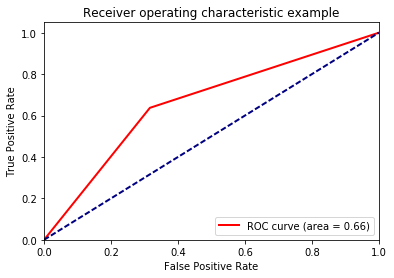

In [12]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, log_model.predict(X_test), pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color = "red", lw = 2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



In the second case, we perform classification using topic shares. The input in the regression is the matrix $\theta$ which  is the distribution of documents over topics in the LDA model. We estimate $\theta$ after running a collapsed Gibbs sampler on the document term matrix $X$. For this exercise we define 100 topics. 

In [13]:
model = lda.LDA(n_topics=100, n_iter=1000, alpha = 0.1, eta = 0.1, random_state=1)
model.fit(np.array(X))

theta = model.doc_topic_
X_train, X_test, Y_train, Y_test = train_test_split(theta, Y, test_size=0.2,random_state=42)

log_model_topic = linear_model.LogisticRegressionCV(Cs = 50, solver = 'liblinear', penalty='l1')
log_model_topic.fit(X=X_train, y=Y_train)


INFO:lda:n_documents: 9994
INFO:lda:vocab_size: 5000
INFO:lda:n_words: 258137
INFO:lda:n_topics: 100
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -3433943
INFO:lda:<10> log likelihood: -2460190
INFO:lda:<20> log likelihood: -2319227
INFO:lda:<30> log likelihood: -2267390
INFO:lda:<40> log likelihood: -2248245
INFO:lda:<50> log likelihood: -2234464
INFO:lda:<60> log likelihood: -2227522
INFO:lda:<70> log likelihood: -2224672
INFO:lda:<80> log likelihood: -2220740
INFO:lda:<90> log likelihood: -2218734
INFO:lda:<100> log likelihood: -2217713
INFO:lda:<110> log likelihood: -2215880
INFO:lda:<120> log likelihood: -2214532
INFO:lda:<130> log likelihood: -2215005
INFO:lda:<140> log likelihood: -2211035
INFO:lda:<150> log likelihood: -2211330
INFO:lda:<160> log likelihood: -2208880
INFO:lda:<170> log likelihood: -2209183
INFO:lda:<180> log likelihood: -2210251
INFO:lda:<190> log likelihood: -2208098
INFO:lda:<200> log likelihood: -2208744
INFO:lda:<210> log likelihood: -2208473
INFO:lda

LogisticRegressionCV(Cs=50, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

The  out-of-sample performance is summarize in the following table. The plot exhibits the ROC curve for the second model.

Logistic regression using topic shares:
             precision    recall  f1-score   support

        0.0       0.62      0.59      0.61       987
        1.0       0.62      0.65      0.63      1012

avg / total       0.62      0.62      0.62      1999




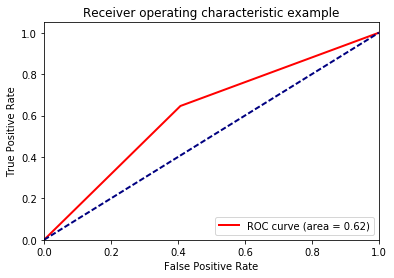

In [14]:
print("Logistic regression using topic shares:\n%s\n" % (metrics.classification_report(Y_test,log_model_topic.predict(X_test))))

fpr, tpr, thresholds = metrics.roc_curve(Y_test, log_model_topic.predict(X_test), pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color = "red", lw = 2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Given the ROC curve associated with each model, and the precision and recall measures, we conclude that the regression on the raw term counts presents better results than the regression on topic shares. However, the difference is out-of-sample performance is not significantly different, which tell us that the dimension reduction properly captures the relation between the documents and the political party.